In [1]:
# Загружаем библиотеки

import numpy as np
import pandas as pd
import gc
import os
import operator

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Закачиваем данные
train_df = pd.read_csv('.../train.csv')
test_df = pd.read_csv('.../test.csv')

In [3]:
train_df.head()

,ID,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000d6aaf2,38000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
1,000fbd867,600000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
2,0027d6b71,10000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
3,0028cbf45,2000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
4,002a68644,14400000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0


In [4]:
test_df.head()

,ID,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,20aa07010,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000137c73,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00021489f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0004d7953,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00056a333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00056d8eb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4459 entries, 0 to 4458
Columns: 4993 entries, ID to 9fc776466
dtypes: float64(1845), int64(3147), object(1)
memory usage: 169.9+ MB


In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49342 entries, 0 to 49341
Columns: 4992 entries, ID to 9fc776466
dtypes: float64(4991), object(1)
memory usage: 1.8+ GB


In [7]:
train_df.describe()

,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,20aa07010,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
count,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,...,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4459.000000,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03
mean,5.944923e+06,1.465493e+04,1.390895e+03,2.672245e+04,4.530164e+03,2.640996e+04,3.070811e+04,1.686522e+04,4.669208e+03,2.569407e+06,...,4.676057e+05,4.446239e+05,8.056219e+05,7.812966e+05,143.529939,1.213809e+05,3.573451e+04,3.123741e+05,9.219960e+04,2.279100e+05
std,8.234312e+06,3.893298e+05,6.428302e+04,5.699652e+05,2.359124e+05,1.514730e+06,5.770590e+05,7.512756e+05,1.879449e+05,9.610183e+06,...,4.068038e+06,4.428889e+06,4.513246e+06,6.839451e+06,9584.318507,4.720709e+06,1.614622e+06,4.318501e+06,1.635993e+06,1.811139e+06
min,3.000000e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,6.000000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.260000e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,8.000000e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e+05,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,4.000000e+07,2.000000e+07,4.000000e+06,2.000000e+07,1.480000e+07,1.000000e+08,2.070800e+07,4.000000e+07,1.040000e+07,3.196120e+08,...,7.600000e+07,1.235880e+08,1.300000e+08,1.444000e+08,640000.000000,3.013120e+08,1.064200e+08,1.400000e+08,6.176800e+07,4.320000e+07


In [8]:
test_df.describe()

,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,20aa07010,dc5a8f1d8,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
count,4.934200e+04,4.934200e+04,4.934200e+04,4.934200e+04,4.934200e+04,4.934200e+04,4.934200e+04,4.934200e+04,4.934200e+04,4.934200e+04,...,4.934200e+04,4.934200e+04,4.934200e+04,4.934200e+04,4.934200e+04,4.934200e+04,4.934200e+04,4.934200e+04,4.934200e+04,4.934200e+04
mean,5.773787e+04,6.258726e+04,1.036752e+05,6.289853e+04,6.713354e+04,8.083879e+04,6.181014e+04,5.515752e+04,1.406324e+06,8.128668e+04,...,1.193910e+05,1.355955e+05,3.242217e+05,1.437856e+05,9.302367e+04,8.047145e+04,6.076865e+04,1.323210e+05,1.675766e+05,1.282487e+05
std,1.745182e+06,2.322787e+06,2.586951e+06,2.765941e+06,3.206124e+06,2.845031e+06,2.780137e+06,1.923517e+06,6.872366e+06,2.378938e+06,...,3.115190e+06,2.598454e+06,3.782996e+06,3.663374e+06,5.041000e+06,2.100210e+06,2.040655e+06,3.592018e+06,3.761816e+06,2.413798e+06
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,1.504447e+08,2.283295e+08,2.758171e+08,3.972621e+08,4.667591e+08,2.852223e+08,4.863751e+08,2.043290e+08,3.435658e+08,2.310167e+08,...,5.351692e+08,1.236547e+08,3.793398e+08,4.025480e+08,9.657530e+08,1.680065e+08,2.497913e+08,3.200000e+08,3.186300e+08,2.189782e+08


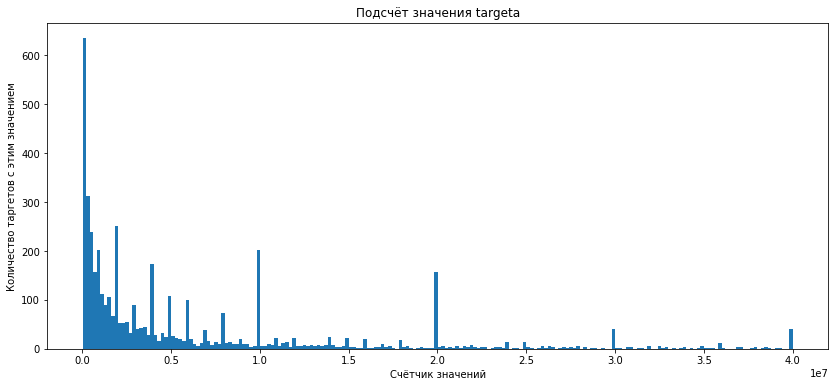

In [9]:
# Визуализация данных

plt.figure(figsize=(14, 6))
plt.hist(train_df.target.values, bins=200)
plt.title('Подсчёт значения targetа')
plt.xlabel('Счётчик значений')
plt.ylabel('Количество таргетов с этим значением')
plt.show()

#### То есть мы видим, что значение 0 есть больше чем у 600 строк, значение 1*1e7 есть у порядка 200 строк и т.д.

In [10]:
# Смотрим, есть ли данные без значений
print("Количество тренировочных фичей без значнеий (NaN Values) = " + str(train_df.columns[train_df.isnull().sum() != 0].size))

Количество тренировочных фичей без значнеий (NaN Values) = 0


In [11]:
print("Количество тестовых фичей без значнеий (NaN Values) = " + str(train_df.columns[train_df.isnull().sum() != 0].size))

Количество тестовых фичей без значнеий (NaN Values) = 0


In [12]:
# Удаляем постоянные значения, т.е. константы, иногда их добавляют в данные 
colsToDel = [] # готовим пустой список, куда поместим колонки для удаления с постоянными данными
for col in train_df.columns: # пробежимся по всем колонкам
    if col != 'ID' and col != 'target': # если колонка - айди или таргет, не трогаем их
        if train_df[col].std() == 0: # с помощью numpy.std смотрим, если значение у колонки == 0, то данные постоянные
            colsToDel.append(col) #добавляем в наш список
        
#избавляемся от этих колонок и в трейне, и в тесте
train_df.drop(colsToDel, axis=1, inplace=True)

test_df.drop(colsToDel, axis=1, inplace=True) 

print("Количество удалённых столбцов: {} \n".format(len(colsToDel)))
print(colsToDel)

Количество удалённых столбцов: 256 

['d5308d8bc', 'c330f1a67', 'eeac16933', '7df8788e8', '5b91580ee', '6f29fbbc7', '46dafc868', 'ae41a98b6', 'f416800e9', '6d07828ca', '7ac332a1d', '70ee7950a', '833b35a7c', '2f9969eab', '8b1372217', '68322788b', '2288ac1a6', 'dc7f76962', '467044c26', '39ebfbfd9', '9a5ff8c23', 'f6fac27c8', '664e2800e', 'ae28689a2', 'd87dcac58', '4065efbb6', 'f944d9d43', 'c2c4491d5', 'a4346e2e2', '1af366d4f', 'cfff5b7c8', 'da215e99e', '5acd26139', '9be9c6cef', '1210d0271', '21b0a54cb', 'da35e792b', '754c502dd', '0b346adbd', '0f196b049', 'b603ed95d', '2a50e001c', '1e81432e7', '10350ea43', '3c7c7e24c', '7585fce2a', '64d036163', 'f25d9935c', 'd98484125', '95c85e227', '9a5273600', '746cdb817', '6377a6293', '7d944fb0c', '87eb21c50', '5ea313a8c', '0987a65a1', '2fb7c2443', 'f5dde409b', '1ae50d4c3', '2b21cd7d8', '0db8a9272', '804d8b55b', '76f135fa6', '7d7182143', 'f88e61ae6', '378ed28e0', 'ca4ba131e', '1352ddae5', '2b601ad67', '6e42ff7c7', '22196a84c', '0e410eb3d', '992e6d1d3', 

In [13]:
%%time 
# Удаляем дубликаты с помощью функции
#Засекаем время
def duplicates_columns(frame):
    groups = frame.columns.to_series().groupby(frame.dtypes).groups #группируем по дтайпу фрэйма
    duplicates = [] #пустой список

    for t, v in groups.items(): #пробегаемся по словарю

        cs = frame[v].columns #колонки
        vs = frame[v] #значения
        lcs = len(cs) #сколько колонок

        for i in range(lcs): #пробегаемся в ренже количества дублирующих колонок
            ia = vs.iloc[:,i].values #значения в этом ренже
            for j in range(i+1, lcs): #теперь проверяем определенный элемент: то есть все колонки, кроме i-того
                ja = vs.iloc[:,j].values #значения колонок в этом рендже, кроме i-ой
                if np.array_equal(ia, ja): #сравниваем i-тый элемент и все остальные
                    duplicates.append(cs[i]) #добавляем в список
                    break

    return duplicates

#запускаем эту функцию для нашего датасета

colsToDel = duplicates_columns(train_df)
print(colsToDel)

['34ceb0081', '8d57e2749', '168b3e5bc', 'a765da8bc', 'acc5b709d']
Wall time: 7min 14s


In [14]:
# удаляем дублирующие колонки
train_df.drop(colsToDel, axis=1, inplace=True) 

test_df.drop(colsToDel, axis=1, inplace=True)

print("Количество удалённых столбцов: {} \n".format(len(colsToDel)))
print(colsToDel)

Количество удалённых столбцов: 5 

['34ceb0081', '8d57e2749', '168b3e5bc', 'a765da8bc', 'acc5b709d']


In [15]:
# Смотрим на уникальность столбцов

def unique_check(train, test): 
    not_unique_columns = []
    flist = [x for x in train.columns if not x in ['ID' ,'target']] 
    for f in flist:
        if len(np.unique(train[f]))<2:
            not_unique_columns.append(f)
    
    return not_unique_columns

n_u_c = unique_check(train_df, test_df)            
print("В наборах данных следующее количество неуникальных столбцов: {}".format(len(n_u_c)))

В наборах данных следующее количество неуникальных столбцов: 0


##### Почему np.log1p? Это решение я нашёл в дискуссиях к соревнованию, таким образом значение таргета приходит к более "челевоческому виду". log1p равноценен значению log(1+x)

In [16]:
X_train = train_df.drop(["ID", "target"], axis=1) #убираем ненужные колонку айди и разделяем трэйне и тесте на фичи и таргеты
y_train = np.log1p(train_df["target"].values) 

X_test = test_df.drop(["ID"], axis=1) 
#добавим val набор данных,равный 20 процентам от общего трэйна
dev_X, val_X, dev_y, val_y = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42) 

#### LightGBM

In [17]:
def lgb_launch(train_X, train_y, val_X, val_y, test_X):
    #задаём параметры для будущего
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 40,
        "learning_rate" : 0.004,
        "bagging_fraction" : 0.6,
        "feature_fraction" : 0.6,
        "bagging_frequency" : 6,
        "bagging_seed" : 42,
        "verbosity" : -1,
        "seed": 42
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y) #датасет трейна
    lgval = lgb.Dataset(val_X, label=val_y) #val датасет
    evals_result = {} #пустой словарь 
    #настраиваем модель
    model = lgb.train(params, lgtrain, 5000, 
                      valid_sets=[lgtrain, lgval], 
                      early_stopping_rounds=100, #задаем значение преждевремнного стопа
                      verbose_eval=150, 
                      evals_result=evals_result) #результаты в словарь 
    
    pred_test_y = np.expm1(model.predict(test_X, num_iteration=model.best_iteration)) # np.expm1 это инверсия np.log1p
    #вывод у функции: предсказания, сама модель, результаты
    #выводим модель для того, чтобы показать как работает важность признаков далее
    return pred_test_y, model, evals_result 

In [18]:
# Тренируем
pred_test, model, evals_result = lgb_launch(dev_X, dev_y, val_X, val_y, X_test)
print("LightGBM тренировка завершена...")

Training until validation scores don't improve for 100 rounds
[150]	training's rmse: 1.5082	valid_1's rmse: 1.53919
[300]	training's rmse: 1.34436	valid_1's rmse: 1.46593
[450]	training's rmse: 1.23324	valid_1's rmse: 1.43393
[600]	training's rmse: 1.14931	valid_1's rmse: 1.41848
[750]	training's rmse: 1.08371	valid_1's rmse: 1.41315
[900]	training's rmse: 1.03011	valid_1's rmse: 1.41131
Early stopping, best iteration is:
[934]	training's rmse: 1.01913	valid_1's rmse: 1.41118
LightGBM тренировка завершена...


In [19]:
# Важность признаков
print("Важность признаков...")
gain = model.feature_importance('gain') #'gain' это средний коэффициент усиления объекта 
                                        #при его использовании в деревьях (по умолчанию)
featureimp = pd.DataFrame({'feature':model.feature_name(), 
                   'split':model.feature_importance('split'), 
                   'gain':100 * gain / gain.sum()}).sort_values('gain', ascending=False)
print(featureimp[:50])

Важность признаков...
        feature  split      gain
4130  f190486d6    752  8.880463
2375  58e2e02e6    702  5.344246
3465  eeb9cd3aa    677  4.358434
4020  15ace8c9f    542  3.131752
2614  9fd594eec    360  2.882999
8     20aa07010    414  2.151287
3571  58232a6fb    359  1.414442
834   6eef030c1    324  1.369470
1457  b43a7cfd5    406  1.252368
3661  491b9ee45    284  1.047073
2687  fb0f5dbfe    416  1.002580
1482  024c577b9    266  1.001906
4508  c47340d97    326  0.889082
2079  58e056e12    343  0.886709
3867  2288333b4    187  0.857178
4343  1702b5bf0    289  0.853304
566   66ace2992    274  0.833897
4185  f74e8f13d    362  0.820876
4028  5c6487af1    207  0.801488
3791  ed8ff54b5    170  0.792289
828   6786ea46d    179  0.776514
3722  d6bb78916    292  0.747566
3220  ced6a7e91    242  0.703042
3886  50e4f96cf    141  0.692474
863   fc99f9426    234  0.673585
34    87ffda550    172  0.628633
1378  6cf7866c1    164  0.627456
3983  45f6d00da    237  0.614132
3811  adb64ff71    23

#### XGBoost

In [20]:
def xgb_launch(train_X, train_y, val_X, val_y, test_X):
    
    #всё аналогично lightgmb
    params = {'objective': 'reg:linear', 
          'eval_metric': 'rmse',
          'eta': 0.001,
          'max_depth': 10, 
          'subsample': 0.6, 
          'colsample_bytree': 0.6,
          'alpha':0.001,
          'random_state': 42, 
          'silent': True}
    
    tr_data = xgb.DMatrix(train_X, train_y)
    va_data = xgb.DMatrix(val_X, val_y)
    
    watchlist = [(tr_data, 'train'), (va_data, 'valid')]
    
    model_xgb = xgb.train(params, tr_data, 2000, watchlist, maximize=False, early_stopping_rounds = 100, verbose_eval=100)
    
    dtest = xgb.DMatrix(test_X)
    xgb_pred_y = np.expm1(model_xgb.predict(dtest, ntree_limit=model_xgb.best_ntree_limit))
    
    return xgb_pred_y, model_xgb

In [21]:
#Тренируем
pred_test_xgb, model_xgb = xgb_launch(dev_X, dev_y, val_X, val_y, X_test)
print("XGB тренировка завршена...")

[0]	train-rmse:14.0877	valid-rmse:14.0768
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 100 rounds.
[100]	train-rmse:12.7683	valid-rmse:12.756
[200]	train-rmse:11.5764	valid-rmse:11.5628
[300]	train-rmse:10.5	valid-rmse:10.4856
[400]	train-rmse:9.52804	valid-rmse:9.51312
[500]	train-rmse:8.65071	valid-rmse:8.63616
[600]	train-rmse:7.85888	valid-rmse:7.84564
[700]	train-rmse:7.14401	valid-rmse:7.13272
[800]	train-rmse:6.49917	valid-rmse:6.49065
[900]	train-rmse:5.91732	valid-rmse:5.91256
[1000]	train-rmse:5.393	valid-rmse:5.39267
[1100]	train-rmse:4.91996	valid-rmse:4.92446
[1200]	train-rmse:4.49387	valid-rmse:4.50465
[1300]	train-rmse:4.11012	valid-rmse:4.12856
[1400]	train-rmse:3.76509	valid-rmse:3.79228
[1500]	train-rmse:3.45519	valid-rmse:3.49217
[1600]	train-rmse:3.1766	valid-rmse:3.22431
[1700]	train-rmse:2.92692	valid-rmse:2.9863
[1800]	train-rmse:2.70344	valid-rmse:2.77585
[1900]	train-rmse:2

#### CatBoost

In [22]:
#Задаём модель, всё аналогично
cb_model = CatBoostRegressor(iterations=500,
                             learning_rate=0.05,
                             depth=10,
                             eval_metric='RMSE',
                             random_seed = 42,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 50,
                             od_wait=20)

In [23]:
#Обучаем
cb_model.fit(dev_X, dev_y,
             eval_set=(val_X, val_y),
             use_best_model=True,
             verbose=50)

pred_test_cat = np.expm1(cb_model.predict(X_test))

0:	learn: 1.7526762	test: 1.6875093	best: 1.6875093 (0)	total: 2.59s	remaining: 21m 30s
50:	learn: 1.4761562	test: 1.5161235	best: 1.5161235 (50)	total: 2m 17s	remaining: 20m 8s
100:	learn: 1.3754008	test: 1.4772765	best: 1.4772765 (100)	total: 4m 32s	remaining: 17m 55s
150:	learn: 1.3164265	test: 1.4622808	best: 1.4620402 (148)	total: 6m 46s	remaining: 15m 40s
200:	learn: 1.2485595	test: 1.4467180	best: 1.4467180 (200)	total: 9m 1s	remaining: 13m 25s
250:	learn: 1.1708898	test: 1.4352949	best: 1.4352949 (250)	total: 11m 15s	remaining: 11m 10s
300:	learn: 1.1167592	test: 1.4323582	best: 1.4322308 (299)	total: 13m 32s	remaining: 8m 56s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 1.431742338
bestIteration = 305

Shrink model to first 306 iterations.


#### Комбинируем решения

In [24]:
submission = pd.read_csv('.../sample_submission.csv')

submission_lgb = pd.DataFrame()
submission_lgb["target"] = pred_test

submission_xgb = pd.DataFrame()
submission_xgb["target"] = pred_test_xgb

submission_cat = pd.DataFrame()
submission_cat["target"] = pred_test_cat

submission["target"] = (submission_lgb["target"] * 0.5 + submission_xgb["target"] * 0.3 + submission_cat["target"] * 0.2)

In [25]:
print(submission.head())
submission.to_csv('.../submission_lgb_xgb_cb', index=False)

          ID        target
0  000137c73  1.382632e+06
1  00021489f  1.366498e+06
2  0004d7953  1.922550e+06
3  00056a333  3.498501e+06
4  00056d8eb  1.455715e+06


### Также присылаю то решение, которое мы обсудили на счёт таблиц в pandas 
#### (Вывести всех сотрудников с зарплатой, больше чем у их босса)

In [26]:
df1 = [{'id_persone' : 1, 'id_boss' : 2, 'salary' : 5} , {'id_persone' : 2, 'id_boss' : 2, 'salary' : 4} , 
       {'id_persone' : 3, 'id_boss' : 1, 'salary' : 8} , {'id_persone' : 4, 'id_boss' : 2, 'salary' : 6} ,
                                                         {'id_persone' : 5, 'id_boss' : 1, 'salary' : 1}]

In [27]:
df1 = pd.DataFrame(df1)

In [28]:
df1

,id_persone,id_boss,salary
0,1,2,5
1,2,2,4
2,3,1,8
3,4,2,6
4,5,1,1


In [29]:
df2 = df1.copy()

In [30]:
df2

,id_persone,id_boss,salary
0,1,2,5
1,2,2,4
2,3,1,8
3,4,2,6
4,5,1,1


In [31]:
df_new = pd.merge(df1, df2, left_on='id_boss', right_on='id_persone', how = 'right')

In [32]:
df_new

,id_persone_x,id_boss_x,salary_x,id_persone_y,id_boss_y,salary_y
0,1.0,2.0,5.0,2,2,4
1,2.0,2.0,4.0,2,2,4
2,4.0,2.0,6.0,2,2,4
3,3.0,1.0,8.0,1,2,5
4,5.0,1.0,1.0,1,2,5
5,NaN,NaN,NaN,3,1,8
6,NaN,NaN,NaN,4,2,6
7,NaN,NaN,NaN,5,1,1


In [33]:
df_new[(df_new['salary_x'] > df_new['salary_y'])]

,id_persone_x,id_boss_x,salary_x,id_persone_y,id_boss_y,salary_y
0,1.0,2.0,5.0,2,2,4
2,4.0,2.0,6.0,2,2,4
3,3.0,1.0,8.0,1,2,5


### А также решение в SQL (с созданием таблицы):

#### CREATE TABLE Employee(id_persone integer, id_boss integer, salary integer);
#### INSERT into Employee(id_persone, id_boss, salary) values(1,2,5);
#### INSERT into Employee(id_persone, id_boss, salary) values(2,2,4);
#### INSERT into Employee(id_persone, id_boss, salary) values(3,1,8);
#### INSERT into Employee(id_persone, id_boss, salary) values(4,2,6);
#### INSERT into Employee(id_persone, id_boss, salary) values(5,1,1);
#### select * from Employee;
#### CREATE TABLE Employee2 SELECT *from Employee;
#### SELECT Employee.id_persone , Employee.id_boss, Employee.salary, Employee2.salary 
#### from Employee 
#### RIGHT JOIN Employee2 ON Employee.id_boss = Employee2.id_persone
#### WHERE Employee.salary > Employee2.salary
#### ORDER BY Employee.id_persone;

#### Результаты как в пандасе